---
# artistic style reconstruction

---

## Import libraries and set up environment

In [1]:
import torch
from torch import nn
import torch.optim as optim

from torchvision.models.vgg import vgg19, VGG19_Weights
from torchvision import transforms

from PIL import Image

constants

In [2]:
IMAGE_PATH = "../data/starry_night.jpg"

RANDOM_SEED = 42
TARGET_LAYERS = [0, 5]
LR = 0.01
NUM_ITERATION = 1000

Set up model

In [3]:
weights = VGG19_Weights.DEFAULT
model = vgg19(weights=weights)
model.eval()
transform = weights.transforms()

In [4]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Freeze the VGG model parameters

In [5]:
for param in model.parameters():
    param.requires_grad = False

In [6]:
image = Image.open(IMAGE_PATH)

## style reconstruction

In [7]:
image_t = transform(image)
batch = image_t.unsqueeze(0)
_, width, height = image_t.shape
print(f"width: {width}, height: {height}")

width: 224, height: 224


In [8]:
image_t.requires_grad

False

In [9]:
def generate_white_noise_image(
    width,
    height,
):
    #white_noise_image = torch.randn(1, 3, width, height)
    white_noise_image = torch.randn(3, width, height)
    white_noise_image = transform(white_noise_image)
    white_noise_image.requires_grad = True
    return white_noise_image

In [10]:
def tensor_to_image(image_t):
    return transforms.Compose([transforms.ToPILImage()])(
        image_t.squeeze(0).cpu().clone().detach()
    )

In [11]:
white_noise_image_t = generate_white_noise_image(width, height)
print(white_noise_image_t.requires_grad)

True


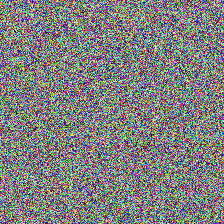

In [12]:
tensor_to_image(white_noise_image_t)

In [13]:
def get_features(model, x):
    """
    forward pass and get the features for all layers
    """
    features = []
    features = {}
    for i, layer in enumerate(model.features):
        x = layer(x)
        features[i] = x
    return features

In [14]:
def gram(features):
    a, b, c = features.shape
    t = features.view(a, b * c)
    gram = torch.mm(t, t.t())
    return gram

### reconstruction with one layer

Loss function

In [15]:
def loss_style(white_noise_features, real_image_features, layer):
    white_noise_features_for_layer = white_noise_features[layer]
    gram_wn = gram(white_noise_features_for_layer)

    real_image_features_for_layer = real_image_features[layer]
    gram_real = gram(real_image_features_for_layer)

    loss = nn.MSELoss()(gram_real, gram_wn)
    return loss

Optimization loop

In [16]:
def reconstruct_style(
    real_image_features,
    layer,
    generated_image=None,  # white noise image
    num_iteration=NUM_ITERATION,
):
    if generated_image == None:
        _, width, height = real_image_features[0].shape
        generated_image = generate_white_noise_image(width=width, height=height)
    optimizer = optim.Adam([generated_image], lr=LR)
    for i in range(num_iteration):
        optimizer.zero_grad()

        generated_image_features = get_features(model, generated_image)
        # Calculate loss
        loss = loss_style(real_image_features, generated_image_features, layer)

        # Backward pass
        loss.backward()

        # Update the image
        optimizer.step()

        # Clip the values to be in the valid range
        with torch.no_grad():
            generated_image.data.clamp_(0, 1)

        print(f"Iteration {i+1}/{num_iteration}, Loss: {loss.item()}")
    new_generated_image = tensor_to_image(generated_image)
    return new_generated_image

---
application:

In [17]:
real_image_features = get_features(model, image_t)
generated_image = reconstruct_style(
    real_image_features=real_image_features,
    layer=0,
    generated_image=white_noise_image_t,
    num_iteration=10,
)

Iteration 1/10, Loss: 48640942080.0
Iteration 2/10, Loss: 82478200.0
Iteration 3/10, Loss: 82784536.0
Iteration 4/10, Loss: 83025744.0
Iteration 5/10, Loss: 83224232.0
Iteration 6/10, Loss: 83391136.0
Iteration 7/10, Loss: 83533200.0
Iteration 8/10, Loss: 83654728.0
Iteration 9/10, Loss: 83758960.0
Iteration 10/10, Loss: 83848232.0


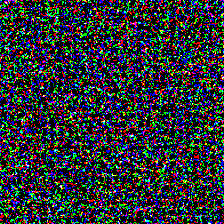

In [18]:
generated_image

In [19]:
generated_image_2 = reconstruct_style(
    real_image_features=real_image_features,
    layer=3,
    num_iteration=10,
)

Iteration 1/10, Loss: 989834117120.0
Iteration 2/10, Loss: 367035552.0
Iteration 3/10, Loss: 361115584.0
Iteration 4/10, Loss: 357049856.0
Iteration 5/10, Loss: 354033536.0
Iteration 6/10, Loss: 351693504.0
Iteration 7/10, Loss: 349823008.0
Iteration 8/10, Loss: 348292224.0
Iteration 9/10, Loss: 347016256.0
Iteration 10/10, Loss: 345936352.0


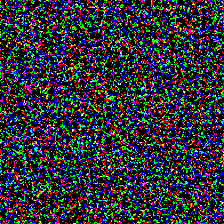

In [20]:
generated_image_2

### style reconstruction with multiple layers

In [21]:
def loss_style_combined_layers(
    white_noise_features, real_image_features, layers, weights=None
):
    losses = []
    for layer in layers:
        loss = loss_style(white_noise_features, real_image_features, layer=layer)
        losses.append(loss)
    total_style_loss = 0
    if weights == None:
        total_style_loss = sum(losses) / len(losses)
    return total_style_loss

In [22]:
def reconstruct_style_combined_layers(
    real_image_features,
    layers,
    generated_image=None,  # white noise image
    num_iteration=NUM_ITERATION,
):
    if generated_image == None:
        _, width, height = real_image_features[0].shape
        generated_image = generate_white_noise_image(width=width, height=height)
    optimizer = optim.Adam([generated_image], lr=LR)
    for i in range(num_iteration):
        optimizer.zero_grad()

        generated_image_features = get_features(model, generated_image)
        # Calculate loss
        loss = loss_style_combined_layers(
            real_image_features, generated_image_features, layers
        )

        # Backward pass
        loss.backward()

        # Update the image
        optimizer.step()

        # Clip the values to be in the valid range
        with torch.no_grad():
            generated_image.data.clamp_(0, 1)

        print(f"Iteration {i+1}/{num_iteration}, Loss: {loss.item()}")
    new_generated_image = tensor_to_image(generated_image)
    return new_generated_image

---
application:

In [25]:
generated_image_combined_layers_2 = reconstruct_style_combined_layers(
    real_image_features=real_image_features,
    layers=list(range(12)),
    num_iteration=2500,
)

Iteration 1/2500, Loss: 672823115776.0
Iteration 2/2500, Loss: 219471728.0
Iteration 3/2500, Loss: 211434832.0
Iteration 4/2500, Loss: 205545344.0
Iteration 5/2500, Loss: 200906096.0
Iteration 6/2500, Loss: 197097472.0
Iteration 7/2500, Loss: 193882992.0
Iteration 8/2500, Loss: 191114928.0
Iteration 9/2500, Loss: 188694976.0
Iteration 10/2500, Loss: 186554320.0
Iteration 11/2500, Loss: 184641328.0
Iteration 12/2500, Loss: 182917328.0
Iteration 13/2500, Loss: 181352016.0
Iteration 14/2500, Loss: 179921072.0
Iteration 15/2500, Loss: 178605584.0
Iteration 16/2500, Loss: 177389200.0
Iteration 17/2500, Loss: 176258528.0
Iteration 18/2500, Loss: 175202592.0
Iteration 19/2500, Loss: 174212480.0
Iteration 20/2500, Loss: 173280160.0
Iteration 21/2500, Loss: 172399168.0
Iteration 22/2500, Loss: 171563824.0
Iteration 23/2500, Loss: 170769120.0
Iteration 24/2500, Loss: 170010352.0
Iteration 25/2500, Loss: 169283568.0
Iteration 26/2500, Loss: 168585648.0
Iteration 27/2500, Loss: 167914064.0
Iterati

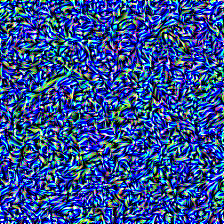

In [26]:
generated_image_combined_layers_2

In [27]:
generated_image_combined_layers_3 = reconstruct_style_combined_layers(
    real_image_features=real_image_features,
    layers=list(range(20)),
    num_iteration=3000,
)

Iteration 1/3000, Loss: 426587979776.0
Iteration 2/3000, Loss: 174207584.0
Iteration 3/3000, Loss: 168220624.0
Iteration 4/3000, Loss: 163786528.0
Iteration 5/3000, Loss: 160260096.0
Iteration 6/3000, Loss: 157335072.0
Iteration 7/3000, Loss: 154841472.0
Iteration 8/3000, Loss: 152672784.0
Iteration 9/3000, Loss: 150759168.0
Iteration 10/3000, Loss: 149051728.0
Iteration 11/3000, Loss: 147511248.0
Iteration 12/3000, Loss: 146110016.0
Iteration 13/3000, Loss: 144826752.0
Iteration 14/3000, Loss: 143641776.0
Iteration 15/3000, Loss: 142540592.0
Iteration 16/3000, Loss: 141512688.0
Iteration 17/3000, Loss: 140549152.0
Iteration 18/3000, Loss: 139642656.0
Iteration 19/3000, Loss: 138785952.0
Iteration 20/3000, Loss: 137973312.0
Iteration 21/3000, Loss: 137199552.0
Iteration 22/3000, Loss: 136459264.0
Iteration 23/3000, Loss: 135749296.0
Iteration 24/3000, Loss: 135067280.0
Iteration 25/3000, Loss: 134410000.0
Iteration 26/3000, Loss: 133775248.0
Iteration 27/3000, Loss: 133160728.0
Iterati

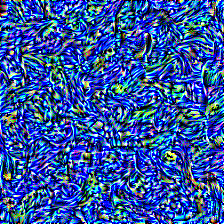

In [28]:
generated_image_combined_layers_3